# Job test


Sarana Maksym's solution

### Task description

* The task is a standard credit scoring problem  - you need to build a model predicting probability of a loan going into bad status (SeriousDlqin2yrs variable)

* You can train your data using file train.csv, where target variable is present

* After you have trained a model, we expect you to send us 
  
 * brief description of technique you used 
  
 * csv file containing calculated probabilities of loan going into bad status using data from file test.csv. File should contain Ident variable and calculated probability variable so we can see the performance of your model

* Good luck

### Data Dictionary

| Variable Name                        | Description                                                                                                                                              | Type       |
|--------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|------------|
| SeriousDlqin2yrs                     | Person experienced 90 days past due delinquency or worse                                                                                                 | Y/N        |
| RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
| age                                  | Age of borrower in years                                                                                                                                 | integer    |
| NumberOfTime30-59DaysPastDueNotWorse | Number of times borrower has been 30-59 days past due but no worse in the last 2 years.                                                                  | integer    |
| DebtRatio                            | Monthly debt payments, alimony,living costs divided by monthy gross income                                                                               | percentage |
| MonthlyIncome                        | Monthly income                                                                                                                                           | real       |
| NumberOfOpenCreditLinesAndLoans      | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)                                                     | integer    |
| NumberOfTimes90DaysLate              | Number of times borrower has been 90 days or more past due.                                                                                              | integer    |
| NumberRealEstateLoansOrLines         | Number of mortgage and real estate loans including home equity lines of credit                                                                           | integer    |
| NumberOfTime60-89DaysPastDueNotWorse | Number of times borrower has been 60-89 days past due but no worse in the last 2 years.                                                                  | integer    |
| NumberOfDependents                   | Number of dependents in family excluding themselves (spouse, children etc.)                                                                              | integer    |
| Ident                                | Case Id                                                                                                                                                  | integer    |

## Solution

### Synopsis

I'm planning to pass the following steps in my solution:

* Read a data and analyze it briefly
* Extract 20% of given train dataset for testing choosed model
* Choose and tuning the model (preprocessing scheme and predicting algorithm) using K-Fold cross validation
* Test choosed model on a new data (saved 20% of the train dataset)
* Learn a model on whole train dataset and predict a target variable of given test dataset

![scheme](Scheme2.png "Scheme")

## Code
Imports:

In [56]:
import pandas as pd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

pd.set_option('precision', 5)

%matplotlib inline

### Reading the data

In [2]:
raw_train = pd.read_csv("Train.csv", sep=";", na_values=" ")
raw_test = pd.read_csv("Test.csv", sep=";", na_values=" ", dtype={"Ident":object})

[raw_train.shape, raw_test.shape]

[(104681, 12), (45319, 11)]

**Attention:** notice that the **Ident** field in the *Test.csv* file has an exponencial format:

![screen](Screen.png "Screen")

It means that the last digit of Idents had been lost, so I decided to import these values as strings. **But they may not be matched during the evaluation!**

Read values:

In [3]:
raw_test.Ident.tail()

45314    30.37385263004518E+015
45315    30.37392011519599E+015
45316    30.37412257604789E+015
45317    30.37419006479836E+015
45318    30.37473000720003E+015
Name: Ident, dtype: object

### Brief exploratory analysis

Test whether there are duplicate entries:

In [4]:
(len(raw_train.Ident.unique()) != len(raw_train.Ident), len(raw_test.Ident.unique()) != len(raw_test.Ident))

(False, False)

Test whether there are common entries in the train and test datasets:

In [5]:
set(raw_train.Ident) & set(raw_test.Ident)

set()

Statistics:

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
raw_train.drop(['Ident'], axis=1).describe().T

/home/maksym/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,104681.00,0.07,0.25,0.00,0.00,0.00,0.00,1.00
RevolvingUtilizationOfUnsecuredLines,104681.00,0.32,0.35,0.00,0.03,0.16,0.56,1.00
age,104681.00,52.48,14.43,29.00,41.00,52.00,63.00,87.00
NumberOfTime3059DaysPastDueNotWorse,104681.00,0.25,0.67,0.00,0.00,0.00,0.00,4.00
DebtRatio,104681.00,329.53,1039.98,0.00,0.17,0.37,0.86,43960.50
MonthlyIncome,83990.00,6386.40,4290.46,1300.00,nan,nan,nan,25000.00
NumberOfOpenCreditLinesAndLoans,104681.00,8.46,4.88,2.00,5.00,8.00,11.00,24.00
NumberOfTimes90DaysLate,104681.00,0.09,0.40,0.00,0.00,0.00,0.00,3.00
NumberRealEstateLoansOrLines,104681.00,0.99,0.99,0.00,0.00,1.00,2.00,4.00
NumberOfTime6089DaysPastDueNotWorse,104681.00,0.06,0.29,0.00,0.00,0.00,0.00,2.00


So, the data in sparse - it has only 6.7% entries with delinquency.

Let's look on count of NANs and zeros:

In [7]:
pd.DataFrame([raw_train.isnull().sum(), raw_test.isnull().sum(), (raw_train == 0).sum(), (raw_test == 0).sum()], 
             index=pd.MultiIndex(levels=[['NANs','Zeros'],['Train','Test']], labels=[[0,0,1,1],[0,1,0,1]]),
             columns=raw_train.columns).transpose()

NANs            Zeros         
                                        Train    Test    Train     Test
SeriousDlqin2yrs                         0.00     nan 97690.00      nan
RevolvingUtilizationOfUnsecuredLines     0.00    0.00  7602.00  3276.00
age                                      0.00    0.00     0.00     0.00
NumberOfTime3059DaysPastDueNotWorse      0.00    0.00 87865.00 38153.00
DebtRatio                                0.00    0.00     0.00     0.00
MonthlyIncome                        20691.00 9040.00     0.00     0.00
NumberOfOpenCreditLinesAndLoans          0.00    0.00     0.00     0.00
NumberOfTimes90DaysLate                  0.00    0.00 98893.00 42769.00
NumberRealEstateLoansOrLines             0.00    0.00 39269.00 16919.00
NumberOfTime6089DaysPastDueNotWorse      0.00    0.00 99393.00 43003.00
NumberOfDependents                    2744.00 1180.00 60701.00 26201.00
Ident                                    0.00    0.00     0.00     0.00

There are two fields with NANs - MonthlyIncome and NumberOfDependents.

Neither of them has share of entries with delinquency over the average value:

In [8]:
raw_train[np.isnan(raw_train.MonthlyIncome)].SeriousDlqin2yrs.mean()

0.05596636218645788

In [9]:
raw_train[np.isnan(raw_train.NumberOfDependents)].SeriousDlqin2yrs.mean()

0.047376093294460644

The MonthlyIncome field has no zero values and I suppose that nan means no income.

The NumberOfDependents field has zero values, but the share on NANs isn't significant:

In [10]:
np.mean([int(np.isnan(x)) for x in raw_train.NumberOfDependents])

0.026212970835204095

Let's look at the age histogram

(array([ 1512.,  1030.,  1199.,  1190.,   747.,   674.,   311.,   182.,
           79.,    67.]),
 array([ 29. ,  34.8,  40.6,  46.4,  52.2,  58. ,  63.8,  69.6,  75.4,
         81.2,  87. ]),
 <a list of 10 Patch objects>)

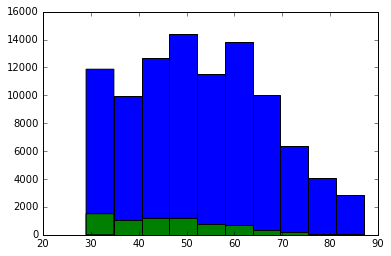

In [11]:
plt.hist(raw_train.age[raw_train.SeriousDlqin2yrs == 0])
plt.hist(raw_train.age[raw_train.SeriousDlqin2yrs == 1])

and at the montly income histogram:

(array([ 2174.,  2228.,  1371.,   627.,   274.,   125.,    70.,    32.,
           28.,    62.]),
 array([     0.,   2500.,   5000.,   7500.,  10000.,  12500.,  15000.,
         17500.,  20000.,  22500.,  25000.]),
 <a list of 10 Patch objects>)

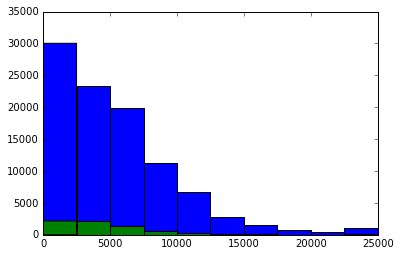

In [12]:
plt.hist(raw_train.MonthlyIncome.fillna(0)[raw_train.SeriousDlqin2yrs == 0])
plt.hist(raw_train.MonthlyIncome.fillna(0)[raw_train.SeriousDlqin2yrs == 1])

Pairwise correlation of columns:

In [13]:
raw_train.drop('Ident', axis=1).corr()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime3059DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime6089DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.00,0.28,-0.12,0.29,-0.02,-0.06,-0.03,0.35,-0.02,0.29,0.04
RevolvingUtilizationOfUnsecuredLines,0.28,1.00,-0.28,0.26,-0.02,-0.10,-0.15,0.28,-0.08,0.22,0.09
age,-0.12,-0.28,1.00,-0.09,0.03,0.10,0.14,-0.10,0.03,-0.09,-0.23
NumberOfTime3059DaysPastDueNotWorse,0.29,0.26,-0.09,1.00,-0.00,-0.01,0.06,0.30,0.02,0.35,0.06
DebtRatio,-0.02,-0.02,0.03,-0.00,1.00,-0.08,0.07,-0.02,0.18,-0.01,-0.06
MonthlyIncome,-0.06,-0.10,0.10,-0.01,-0.08,1.00,0.27,-0.07,0.37,-0.05,0.18
NumberOfOpenCreditLinesAndLoans,-0.03,-0.15,0.14,0.06,0.07,0.27,1.00,-0.12,0.45,-0.04,0.07
NumberOfTimes90DaysLate,0.35,0.28,-0.10,0.30,-0.02,-0.07,-0.12,1.00,-0.09,0.37,0.03
NumberRealEstateLoansOrLines,-0.02,-0.08,0.03,0.02,0.18,0.37,0.45,-0.09,1.00,-0.04,0.14
NumberOfTime6089DaysPastDueNotWorse,0.29,0.22,-0.09,0.35,-0.01,-0.05,-0.04,0.37,-0.04,1.00,0.03


There is no pair with strong correlation

### Data preprocessing

I propose:

* Drop out the Ident field
* Add 0/1 feature for NANs in the NumberOfDependents fields - it may have some reason
* Fill in by 0 all NANs in the MonthlyIncome and NumberOfDependents fields
* Add an income per person, that remains after debt payments

In [124]:
def proccessData(ds):
    new_ds = pd.DataFrame.copy(ds)
    new_ds.drop('Ident', inplace=True, axis=1)
    new_ds['NullInDependents'] = [int(np.isnan(x)) for x in new_ds.NumberOfDependents] 
    new_ds.MonthlyIncome.fillna(0, inplace=True)
    new_ds.NumberOfDependents.fillna(0, inplace=True)
    new_ds['IncOnPers'] = new_ds.MonthlyIncome * (1.0 - new_ds.DebtRatio) / (1.0 + new_ds.NumberOfDependents)
    return new_ds

### Dividing on my train and test sets

In [14]:
srch_train, srch_test = train_test_split(raw_train, test_size=0.2, random_state=42, 
                                         stratify=raw_train.SeriousDlqin2yrs)

### Model choosing and tuning

Now I'll write a function for model probing. It uses stratified K-Fold validation for model evaluation. As a metric I choose AUC.

In [76]:
def kFoldValidation(data, prD, prVal, modelParam=[0, {}]):
    N_folds = 5
    data = prD(data)
    
    skf = StratifiedKFold(data.SeriousDlqin2yrs, n_folds=N_folds, shuffle=True, random_state=1234)
    
    res = 0
    for train_index, test_index in skf:
        res += prVal(data.ix[data.index[train_index]], data.ix[data.index[test_index]], modelParam)
        
    return float(res) / N_folds

Now I'll try several models with two choises:

* Original data
* With dropping out of part of non-default data. That increases the percentage of defaults in the data set and some algorithms may work better

#### Logistic regression

Without Drop Out:

In [125]:
def logisticRegr(train, test, modelParam):
    model = LogisticRegression(**modelParam[1])
    model = model.fit(train.drop(['SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])
    predicted = model.predict_proba(test.drop(['SeriousDlqin2yrs'], axis=1))
    return roc_auc_score(test['SeriousDlqin2yrs'], predicted[:,np.dot([0, 1], model.classes_)])

kFoldValidation(srch_train, proccessData, logisticRegr)

0.7637117321525333

With Drop Out:

In [126]:
def logisticRegrDropOut(train, test, modelParam):
    model = LogisticRegression(**modelParam[1])
    
    train = train[[(x == 1) or (random.random() < modelParam[0]) for x in train.SeriousDlqin2yrs]]
    
    model = model.fit(train.drop(['SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])
    predicted = model.predict_proba(test.drop(['SeriousDlqin2yrs'], axis=1))
    return roc_auc_score(test['SeriousDlqin2yrs'], predicted[:,np.dot([0, 1], model.classes_)])

random.seed = 1234
kFoldValidation(srch_train, proccessData, logisticRegrDropOut, [0.3, {}])

0.7772847355052322

#### Naive Bayes

Without Drop Out:

In [127]:
def NB(train, test, modelParam):
    model = GaussianNB(**modelParam[1])
    model = model.fit(train.drop(['SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])
    predicted = model.predict_proba(test.drop(['SeriousDlqin2yrs'], axis=1))
    return roc_auc_score(test['SeriousDlqin2yrs'], predicted[:,np.dot([0, 1], model.classes_)])

kFoldValidation(srch_train, proccessData, NB)

0.6408451035177615

With Drop Out:

In [128]:
def NBDropOut(train, test, modelParam):
    model = GaussianNB(**modelParam[1])
    
    train = train[[(x == 1) or (random.random() < modelParam[0]) for x in train.SeriousDlqin2yrs]]
    
    model = model.fit(train.drop(['SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])
    predicted = model.predict_proba(test.drop(['SeriousDlqin2yrs'], axis=1))
    return roc_auc_score(test['SeriousDlqin2yrs'], predicted[:,np.dot([0, 1], model.classes_)])

random.seed = 1234
kFoldValidation(srch_train, proccessData, NBDropOut, [0.3, {}])

0.6410850071579816

#### Random forest

Without Drop Out:

In [129]:
def RF(train, test, modelParam):
    model = RandomForestRegressor(**modelParam[1])
    model = model.fit(train.drop(['SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])
    predicted = model.predict(test.drop(['SeriousDlqin2yrs'], axis=1))
    return roc_auc_score(test['SeriousDlqin2yrs'], predicted)

kFoldValidation(srch_train, proccessData, RF)

0.7767652020803762

With Drop Out:

In [130]:
def RFDropOut(train, test, modelParam):
    model = RandomForestRegressor(**modelParam[1])
    
    train = train[[(x == 1) or (random.random() < modelParam[0]) for x in train.SeriousDlqin2yrs]]
    
    model = model.fit(train.drop(['SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])
    predicted = model.predict(test.drop(['SeriousDlqin2yrs'], axis=1))
    return roc_auc_score(test['SeriousDlqin2yrs'], predicted)

random.seed = 1234
kFoldValidation(srch_train, proccessData, RFDropOut, [0.3, {}])

0.815461575832277

#### XGBoost

Without Drop Out:

In [131]:
def XGB(train, test, modelParam):
    gbm = xgb.XGBRegressor(**modelParam[1]).fit(train.drop(['SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])
    predicted = gbm.predict(test.drop(['SeriousDlqin2yrs'], axis=1))
    return roc_auc_score(test['SeriousDlqin2yrs'], predicted)

kFoldValidation(srch_train, proccessData, XGB, [0, {'max_depth':4, 'n_estimators':500, 'learning_rate':0.05}])

0.8614168411300623

With Drop Out:

In [132]:
def XGBDropOut(train, test, modelParam):
    train = train[[(x == 1) or (random.random() < modelParam[0]) for x in train.SeriousDlqin2yrs]]
    gbm = xgb.XGBRegressor(**modelParam[1]).fit(train.drop(['SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])
    predicted = gbm.predict(test.drop(['SeriousDlqin2yrs'], axis=1))
    return roc_auc_score(test['SeriousDlqin2yrs'], predicted)

random.seed = 1234
kFoldValidation(srch_train, proccessData, XGBDropOut, [0.3, 
                                                       {'max_depth':4, 'n_estimators':500, 'learning_rate':0.05}])

0.8604112253380484

##### Tuning

The main idea is to try to improve performance of model, but not to overfit it. 

###### Random Forest with Drop Out

Number of trees

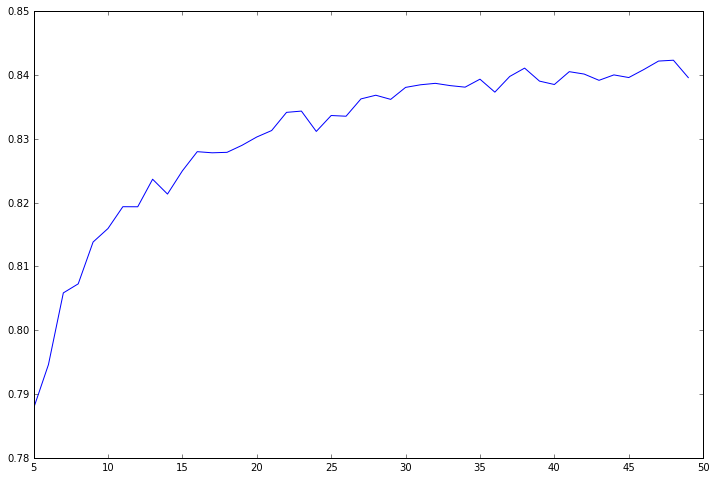

In [91]:
random.seed = 1234
gr = np.arange(5, 50, 1)
res = []

for g in gr:
    res.append(kFoldValidation(srch_train, proccessData, RFDropOut, [0.3, {'n_estimators':g, 'n_jobs':4}]))
    
plt.figure(figsize=(12,8))
plt.plot(gr, res)

Max fitures

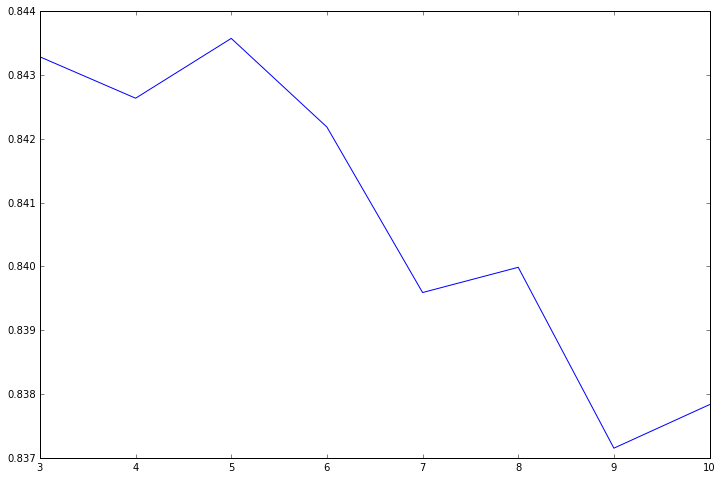

In [93]:
gr = np.arange(3, 11, 1)
res = []

for g in gr:
    res.append(kFoldValidation(srch_train, proccessData, RFDropOut,
                               [0.3, {'n_estimators':30, 'max_features':g, 'n_jobs':4}]))
    
plt.figure(figsize=(12,8))
plt.plot(gr, res)

Drop Out ratio

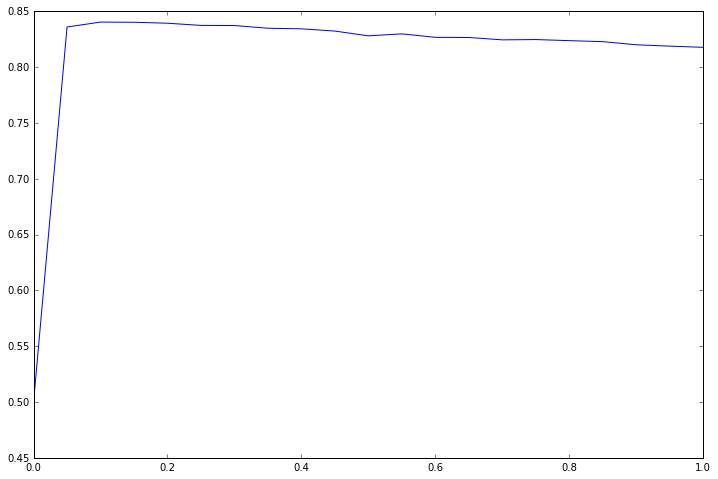

In [94]:
random.seed = 1234

gr = np.arange(0, 1.05, 0.05)
res = []

for g in gr:
    res.append(kFoldValidation(srch_train, proccessData, RFDropOut, [g, {'n_estimators':30, 'n_jobs':4}]))
    
plt.figure(figsize=(12,8))
plt.plot(gr, res)

###### XGBoost

Number of estimators (max depth = 1)

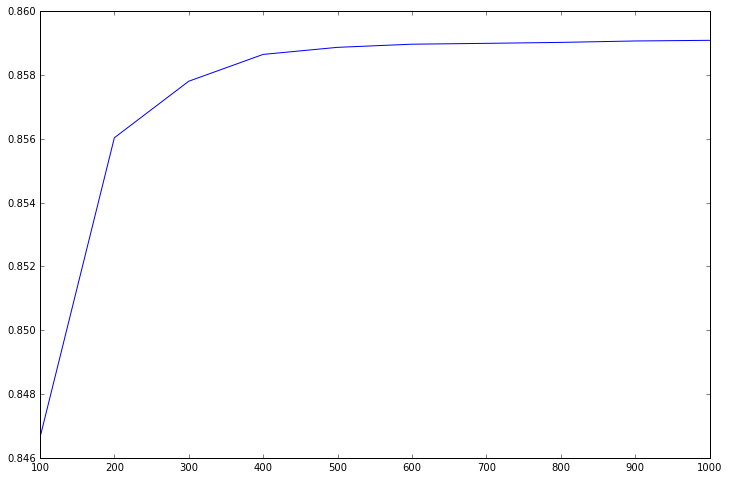

In [96]:
gr = np.arange(100, 1100, 100)
res = []

for g in gr:
    res.append(kFoldValidation(srch_train, proccessData, XGB,
                               [0, {'max_depth':1, 'n_estimators':g, 'learning_rate':0.05}]))
    
plt.figure(figsize=(12,8))
plt.plot(gr, res)

Number of estimators (max depth = 2)

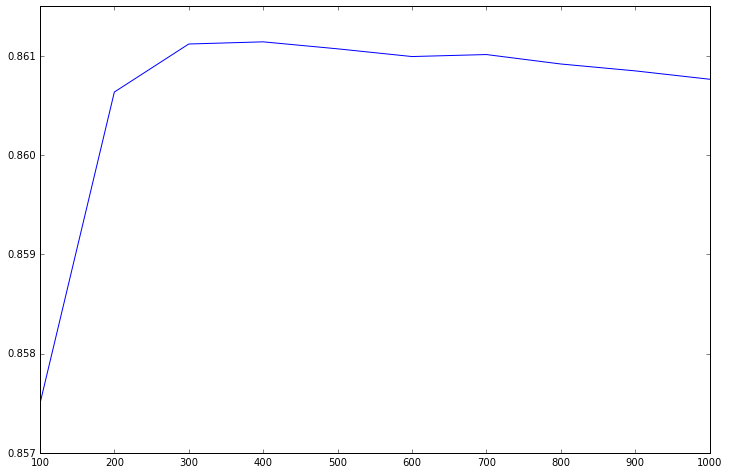

In [152]:
gr = np.arange(100, 1100, 100)
res = []

for g in gr:
    res.append(kFoldValidation(srch_train, proccessData, XGB,
                               [0, {'max_depth':2, 'n_estimators':g, 'learning_rate':0.05}]))
    
plt.figure(figsize=(12,8))
plt.plot(gr, res)

Max depth (Number of estimators = 500)

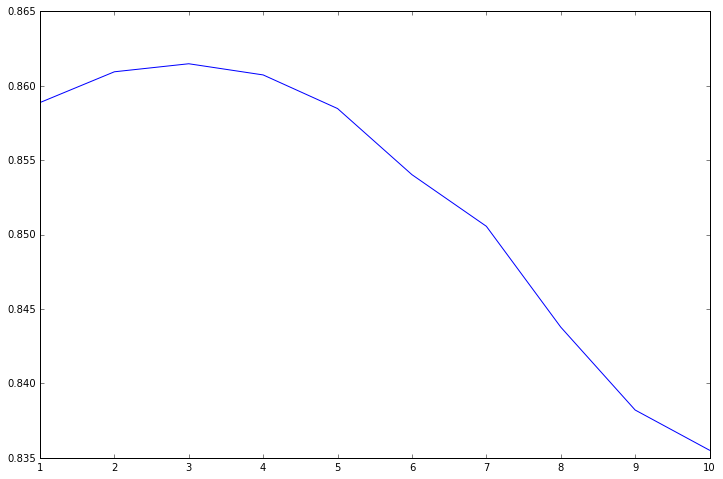

In [99]:
gr = np.arange(1, 11, 1)
res = []

for g in gr:
    res.append(kFoldValidation(srch_train, proccessData, XGB,
                               [0, {'max_depth':g, 'n_estimators':500, 'learning_rate':0.05}]))
    
plt.figure(figsize=(12,8))
plt.plot(gr, res)

Learning rate

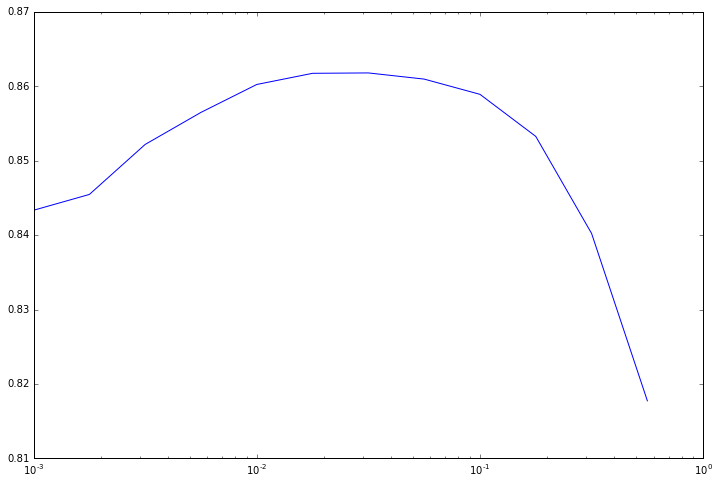

In [118]:
gr = [10 ** x  for x in np.arange(-3, 0, 0.25)]
res = []

for g in gr:
    res.append(kFoldValidation(srch_train, proccessData, XGB,
                               [0, {'max_depth':3, 'n_estimators':500, 'learning_rate':g}]))
    
plt.figure(figsize=(12,8))
plt.plot(gr, res)
plt.xscale('log')
plt.show()

Optimum 10^-1.8 = 0.016

### Testing on the new data

In [133]:
RFDropOut(proccessData(srch_train), proccessData(srch_test), [0.2, {'n_estimators':30, 'n_jobs':4}])

0.83342416081230286

In [134]:
XGB(proccessData(srch_train), proccessData(srch_test), 
    [0, {'max_depth':3, 'n_estimators':500, 'learning_rate':0.016}])

0.8630035149978097

Results are close to the previous ones, hence the models aren't overfitted

### Test data prediction

XGBoost model

In [149]:
train = proccessData(raw_train)
test = proccessData(raw_test)

gbm = xgb.XGBRegressor(**{'max_depth':3, 'n_estimators':500, 'learning_rate':0.016}).fit(
    train.drop(['SeriousDlqin2yrs'], axis=1),
    train['SeriousDlqin2yrs'])

predicted = [max(0, min(1, x)) for x in gbm.predict(test)]

result = pd.DataFrame([raw_test.Ident.values, predicted], index=['Ident','probability']).T

In [150]:
result.to_csv('Result.csv', index=False, quoting=2)